In [50]:
import requests
import seaborn as sns
import pandas as pd
import time

In [3]:
urlcook = 'https://api.pushshift.io/reddit/search/submission/?subreddit=cooking&metadata=true&size=500&is_self=true'
urlbegin = 'https://api.pushshift.io/reddit/search/submission?subreddit=cookingforbeginners&metadata=true&size=500&is_self=true'

In [4]:
rescook = requests.get(urlcook)
resbegin = requests.get(urlbegin)

In [5]:
begindict = resbegin.json()
cookdict= rescook.json()

In [6]:
begindict.keys()

dict_keys(['data', 'metadata'])

In [9]:

begindict.get('data')[1].get('created_utc')

1651021913

In [15]:
plotter = [begindict.get('data')[i].get('created_utc') for i in range(len(begindict.get('data')))]

In [19]:
len(plotter)

100

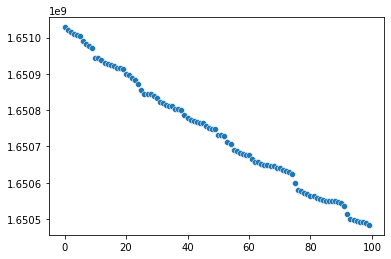

In [21]:
sns.scatterplot(x=list(range(100)),y=plotter);

All of this was just confirmation that the scrape goes back monotonically in time. Of note, while size was set to 500, we only got 100 hits, suggesting we should be careful about how our scraping works and give time to pulls- and it might be the case that their API (https://github.com/pushshift/api) is outdated. Moving forwards, let's see what data keys there are that can be of interest

In [30]:
list(begindict.get('data')[0].keys())

['all_awardings',
 'allow_live_comments',
 'author',
 'author_flair_css_class',
 'author_flair_richtext',
 'author_flair_text',
 'author_flair_type',
 'author_fullname',
 'author_is_blocked',
 'author_patreon_flair',
 'author_premium',
 'awarders',
 'can_mod_post',
 'contest_mode',
 'created_utc',
 'domain',
 'full_link',
 'gildings',
 'id',
 'is_created_from_ads_ui',
 'is_crosspostable',
 'is_meta',
 'is_original_content',
 'is_reddit_media_domain',
 'is_robot_indexable',
 'is_self',
 'is_video',
 'link_flair_background_color',
 'link_flair_richtext',
 'link_flair_template_id',
 'link_flair_text',
 'link_flair_text_color',
 'link_flair_type',
 'locked',
 'media_only',
 'no_follow',
 'num_comments',
 'num_crossposts',
 'over_18',
 'parent_whitelist_status',
 'permalink',
 'pinned',
 'pwls',
 'retrieved_on',
 'score',
 'selftext',
 'send_replies',
 'spoiler',
 'stickied',
 'subreddit',
 'subreddit_id',
 'subreddit_subscribers',
 'subreddit_type',
 'thumbnail',
 'title',
 'total_awards_r

We'll be looking at text, primarily, but it seems that other factors could be useful. Although, some are just cheating- ex, since r/cooking is a much more popular subreddit than r/cookingforbeginners, we should expect to see far more awards on average, along with other factors.

In [31]:
begindict.get('data')[0].get('subreddit_subscribers')

526815

In [32]:
begindict.get('data')[99].get('subreddit_subscribers')

517775

Interestingly, they seem to be able to track subreddit subscribers at posting. If nothing else, we can use this information to see how, if at all, the subreddit changed over the years.

In [34]:
begindict.get('data')[0]

{'all_awardings': [],
 'allow_live_comments': False,
 'author': 'catalinados',
 'author_flair_css_class': None,
 'author_flair_richtext': [],
 'author_flair_text': None,
 'author_flair_type': 'text',
 'author_fullname': 't2_70k700a8',
 'author_is_blocked': False,
 'author_patreon_flair': False,
 'author_premium': False,
 'awarders': [],
 'can_mod_post': False,
 'contest_mode': False,
 'created_utc': 1651028669,
 'domain': 'self.cookingforbeginners',
 'full_link': 'https://www.reddit.com/r/cookingforbeginners/comments/uctswb/why_are_there_white_spots_on_my_mayo/',
 'gildings': {},
 'id': 'uctswb',
 'is_created_from_ads_ui': False,
 'is_crosspostable': True,
 'is_meta': False,
 'is_original_content': False,
 'is_reddit_media_domain': False,
 'is_robot_indexable': True,
 'is_self': True,
 'is_video': False,
 'link_flair_background_color': '#7193ff',
 'link_flair_richtext': [],
 'link_flair_template_id': '8a236e74-32f2-11e9-b9df-0ecae544881c',
 'link_flair_text': 'Question',
 'link_flair_t

Given what we see, for submissions, the only relevant keys are 'created_utc', 'domain', 'selftext', 'subreddit_subscribers', 'title'

We want to be flexible, so let's also look at comments

In [35]:
beginurl = 'https://api.pushshift.io/reddit/search/comment/?subreddit=cookingforbeginners&metadata=true&size=500'

In [36]:
beginres = requests.get(beginurl)
dictbegin = beginres.json()

In [38]:
len(dictbegin.get('data'))

100

In [41]:
dictbegin.get('data')[0]

{'all_awardings': [],
 'archived': False,
 'associated_award': None,
 'author': '96dpi',
 'author_flair_background_color': None,
 'author_flair_css_class': None,
 'author_flair_richtext': [],
 'author_flair_template_id': None,
 'author_flair_text': None,
 'author_flair_text_color': None,
 'author_flair_type': 'text',
 'author_fullname': 't2_bsnif',
 'author_patreon_flair': False,
 'author_premium': False,
 'body': 'Start here for you tempura\n\nhttps://www.seriouseats.com/the-food-lab-tempura-vegetables-shrimp-recipe\n\nAnd find a Thai chili sauce at the grocery store or online. Toss it in the sauce after frying.',
 'body_sha1': 'f1de3685810d0f426694084ee7c4eee50af46f3f',
 'can_gild': True,
 'collapsed': False,
 'collapsed_because_crowd_control': None,
 'collapsed_reason': None,
 'collapsed_reason_code': None,
 'comment_type': None,
 'controversiality': 0,
 'created_utc': 1651034224,
 'distinguished': None,
 'gilded': 0,
 'gildings': {},
 'id': 'i6d2mfx',
 'is_submitter': False,
 'link

Looking at this, you can tie comments to a specific post by permalink and removing the final '/' pair. Whether that will be useful is yet to be seen, but let's start with as broad a search as we can. In that case, what we need is 'created_utc','body','permalink'

Given what we know, let's try and make an iterable set of instructions that will collect every submission and comment (with relevant information) from the last 4 years. That should easily pass the minimum number of posts and give us a healthy amount of data to crunch to figure out differences

In [70]:
cforbbaseurl = 'https://api.pushshift.io/reddit/search/submission/?subreddit=cookingforbeginners&metadata=true&size=500'
cookingbaseurl = 'https://api.pushshift.io/reddit/search/submission/?subreddit=cooking&metadata=true&size=500'
present_time = 1651037065 #Tuesday, April 26, 2022 10:24:25 PM GMT -7:00, for the curious

In [42]:
dictbegin.get('data')[0].get('created_utc')

1651034224

In [67]:
cforbbaseurl + '?before=' + str(present_time)

'https://api.pushshift.io/reddit/search/submission/?subreddit=cookingforbeginners&metadata=true&size=500?is_self=true?before=1651037065'

In [49]:
starttime = 1524806665

^4 years ago, more or less. Credit to https://www.epochconverter.com/

In [75]:
Csubtimelist = []
Csubdomainlist = []
Csubtextlist = []
Csubscriberlist = []
Csubtitlelist = []
Bsubtimelist = []
Bsubdomainlist = []
Bsubtextlist = []
Bsubscriberlist = []
Bsubtitlelist = []
fields = '&fields=created_utc,domain,selftext,subreddit_subscribers,title'
#all of these lists should be combined together and dealt with together, but as long as they're pulling from the same places,
#in the same order, it's not too bad to keep them separate just to keep them legible before tossing into a DF
while present_time > starttime:
    time.sleep(2) #to avoid any API overload issues- max calls should be 60/min or 1/sec. 2 calls bc 2 subreddits, so 2 sec sleep
    subcforb = requests.get(cforbbaseurl+'?before='+str(present_time)+fields)
    subcook = requests.get(cookingbaseurl+'?before='+str(present_time)+fields)
    subcookdata = subcook.json().get('data')
    subcforbdata = subcforb.json().get('data')
 
    
    Csubtimelist.extend([subcookdata[i].get('created_utc') for i in range(len(subcookdata))])
    Csubdomainlist.extend([subcookdata[i].get('domain') for i in range(len(subcookdata))])
    Csubtextlist.extend([subcookdata[i].get('selftext') for i in range(len(subcookdata))])
    Csubscriberlist.extend([subcookdata[i].get('subreddit_subscribers') for i in range(len(subcookdata))])
    Csubtitlelist.extend([subcookdata[i].get('title') for i in range(len(subcookdata))])
    
    Bsubtimelist.extend([subcforbdata[i].get('created_utc') for i in range(len(subcforbdata))])
    Bsubdomainlist.extend([subcforbdata[i].get('domain') for i in range(len(subcforbdata))])
    Bsubtextlist.extend([subcforbdata[i].get('selftext') for i in range(len(subcforbdata))])
    Bsubscriberlist.extend([subcforbdata[i].get('subreddit_subscribers') for i in range(len(subcforbdata))])
    Bsubtitlelist.extend([subcforbdata[i].get('title') for i in range(len(subcforbdata))])
    
    
    
    present_time = Bsubtimelist[-1]
    print(present_time)
    
    

1650884441
1650884441
1650884441


KeyboardInterrupt: 

In [79]:
subcforb = requests.get(cforbbaseurl+'?before='+str(present_time)+fields)
subcook = requests.get(cookingbaseurl+'?before='+str(present_time)+fields)
subcookdata = subcook.json().get('data')
subcforbdata = subcforb.json().get('data')

In [89]:
subcook.json().get('data')[-1].get('created_utc')

1651040152

In [64]:
strtest= cforbbaseurl+'?before='+str(present_time)

In [92]:
[subcookdata[i].get('created_utc') for i in range(len(subcookdata))]

[1651040152,
 1651038497,
 1651037272,
 1651036707,
 1651033692,
 1651031961,
 1651031959,
 1651031105,
 1651029082,
 1651028735,
 1651027990,
 1651027256,
 1651027237,
 1651026608,
 1651026486,
 1651025971,
 1651025910,
 1651025769,
 1651025650,
 1651024741,
 1651024652,
 1651024620,
 1651023283,
 1651022099,
 1651022053]

In [94]:
subcookdata

[{'created_utc': 1651040152,
  'domain': 'self.Cooking',
  'selftext': 'Do you have a good method for making decent fajita chicken on a non stick pan? (concerned with seasoning/marinade, oil use, heat etc, no need to list vegetables etc).',
  'subreddit_subscribers': 3215958,
  'title': 'Chicken Fajita method for non stick?'},
 {'created_utc': 1651038497,
  'domain': 'self.Cooking',
  'selftext': '\n\nDaripada beli es krim yang makin lama makin mahal yuk kita membuat resep mudah cara membuat es krim oreo yang super duper enak\n\nBahan-bahan\n.Goriorio\n. susu cair\n.coklat blok\n. stik\n\nhttps://youtu.be/1Pp8AnXMUGY',
  'subreddit_subscribers': 3215921,
  'title': 'Ice Cream Oreo Magnum'},
 {'created_utc': 1651037272,
  'domain': 'self.Cooking',
  'selftext': "I wanted to buy chicken thighs yesterday and since I have not bought them in about 5 years I have forgotten what the raw meat with skin on is supposed to look like. This one had a bunch of yellow spots on it. All of them on the 

In [91]:
ls = [1]
ls.extend([i for i in range(10)])
ls

[1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]